In [61]:
%matplotlib inline

import numpy as np
from scipy import stats
from sklearn.gaussian_process import GaussianProcessClassifier
from matplotlib import pyplot as pl
from matplotlib import cm
import csv
from altair import Chart

In [62]:
participant = 'stratus124'
# tested: 125, 132

In [63]:
# The data is stored in a csv file that has three columns,
# one for each frequency and one for the percept report.

# Define a function that cleans this data (this is used for)
# both the test and the training data later:
def cleandata(data):
    assert data.shape[1] == 3, "Data not in the right format."
    
    # trim the data of all timepoints where nothing was reported
    # (this usually also removes the beginning and end of trials)
    data = data[np.logical_not(np.isnan(data[:, 2])), :]
    
    # downsample the data (to avoid memory issues!)
    downsamplefactor = 18  # choose how much you want to throw out
    data = data[np.arange(0, data.shape[0], downsamplefactor), :]
    
    # split into x and y
    x = data[:, 0:2]
    y = data[:, 2]
    return x, y

In [64]:
# Load training data from the file matlab generates
traindata = np.genfromtxt(participant + '_sim.csv', delimiter=',', skip_header=1,
                          missing_values=['NaN', 'nan'], filling_values=None)

# Clean this data
trainx, trainy = cleandata(traindata)
traindata = None  # delete to save memory!

In [65]:
# Create a gaussian process class
# nugget is the parameter that defines how much regularization there is
# gp = GaussianProcess(theta0=5e-1, thetaL=1e-3, thetaU=3,
#                      nugget=1e-12)
gp = GaussianProcessClassifier()

# train this class on the data
print('training...')
gp.fit(trainx, trainy)
print('fit done..!')

# Discard all training data to preserve memory
trainx = trainy = None

training...
fit done..!


In [66]:
# load test data
testdata = np.genfromtxt(participant + '_rival.csv', delimiter=',', skip_header=1,
                         missing_values=['NaN', 'nan'], filling_values=None)
testx, testy = cleandata(testdata)  # clean data
testdata = None  # clear from memory

In [67]:
# now get a prediction for all points in the test data
print('predicting...')
predicty = gp.predict(testx)
proby = gp.predict_proba(testx)
print('predicted...!')

predicting...
predicted...!


In [68]:
for percept in [-1, 0, 1]:
    print(str(np.mean(predicty[np.equal(testy, percept)])) +
          '+-' + str(np.std(predicty[np.equal(testy, percept)])))


-0.0902255639098+-0.995921356141
-0.228187919463+-0.973617108216
-0.0501156515035+-0.998743421242


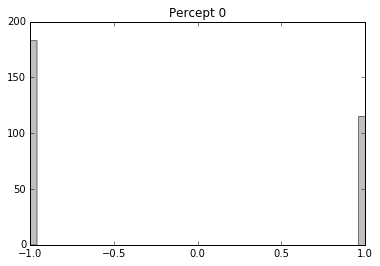

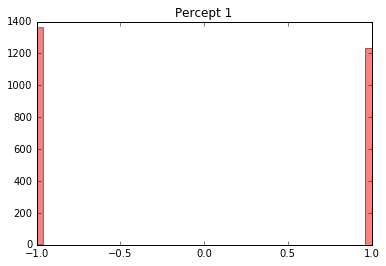

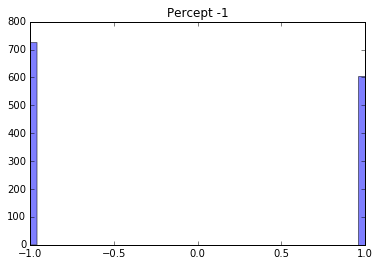

In [69]:
# Categorical Predictions
colors = ['gray', 'red', 'blue']
for percept in [-1, 0, 1]:
    fig = pl.figure(percept)
    n, bins, patches = pl.hist(predicty[np.equal(testy, percept)], num_bins, facecolor=colors[percept], alpha=0.5)
    pl.title('Percept ' + str(percept))


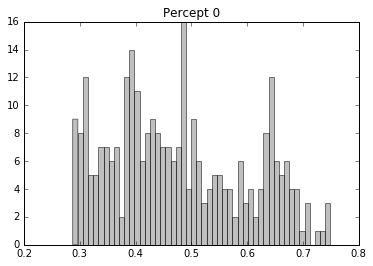

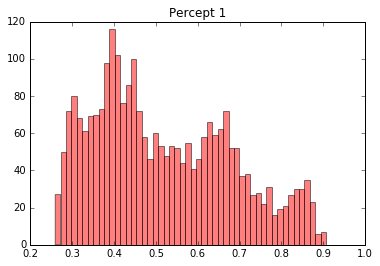

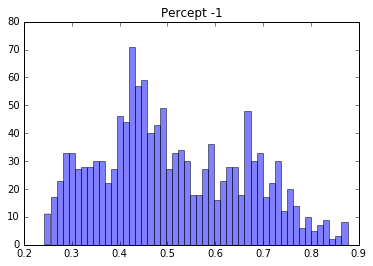

In [70]:
# Prediction Probabilities
colors = ['gray', 'red', 'blue']
num_bins = 50
for percept in [-1, 0, 1]:
    fig = pl.figure(percept)
    n, bins, patches = pl.hist(proby[np.equal(testy, percept), 1], num_bins, facecolor=colors[percept], alpha=0.5)
    pl.title('Percept ' + str(percept))